In [1]:
from os import scandir, path
import math

import numpy as np
from sklearn.metrics import confusion_matrix
import tensorflow as tf

from src.image_loader import load_images
from src.utils import one_hot, shuffle_n, arg_top_n, remove_ticks
from src.networks import AlexNet

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# read the class names from the subdirectories in the training data
class_names = [f.name for f in scandir("./data/train/raw") if f.is_dir()]
print(class_names)

# collect the images, labels, and individual file paths
# we'll be reloading images later with transformations, so keep track of the image paths that are used for training instead of cross-validation
train_imgs_ord = []
train_labels_ord = []
file_paths_ord = []

for i, name in enumerate(class_names):
    imgs, file_paths = load_images("./data/train/resized/%s/*.png" % name, return_file_paths=True)
    train_imgs_ord.extend(imgs)
    train_labels_ord.extend([i] * len(imgs))
    file_paths_ord.extend(file_paths)

train_imgs_ord = np.array(train_imgs_ord, dtype=np.float32)
print(train_imgs_ord.shape)
train_labels_ord = one_hot(train_labels_ord)
print(train_labels_ord.shape)

['Charlock', 'Common Chickweed', 'Loose Silky-bent', 'Black-grass', 'Cleavers', 'Small-flowered Cranesbill', 'Scentless Mayweed', 'Fat Hen', 'Common wheat', 'Shepherds Purse', 'Sugar beet', 'Maize']
(4750, 224, 224, 3)
(4750, 12)


In [3]:
dev_fraction = 0.15
num_dev_examples = math.floor(len(train_imgs_ord) * dev_fraction)
train_imgs_shuf, train_labels_shuf, file_paths_shuf = shuffle_n(train_imgs_ord, train_labels_ord, file_paths_ord)
train_data, train_labels, train_file_paths = (train_imgs_shuf[:-num_dev_examples],
                                              train_labels_shuf[:-num_dev_examples],
                                              file_paths_shuf[:-num_dev_examples])
dev_data, dev_labels, dev_file_paths = (train_imgs_shuf[-num_dev_examples:],
                           train_labels_shuf[-num_dev_examples:],
                           file_paths_shuf[-num_dev_examples:])

# delete unused varaibles to save memory. yes, this is important for later!
del train_imgs_ord, train_labels_ord, file_paths_ord, train_imgs_shuf, train_labels_shuf, file_paths_shuf, imgs, file_paths
print(train_data.shape)
print(train_labels.shape)
print(dev_data.shape)
print(dev_labels.shape)

(4038, 224, 224, 3)
(4038, 12)
(712, 224, 224, 3)
(712, 12)


In [4]:
IMG_SIZE = 224
num_classes = len(class_names)

In [5]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(None, IMG_SIZE, IMG_SIZE, 3), name="X")
Y = tf.placeholder(tf.float32, shape=(None, num_classes), name="Y")
dropout = tf.constant(0)

model = AlexNet(X, dropout, num_classes)

losses = tf.nn.softmax_cross_entropy_with_logits(logits=model.logits, labels=Y)
predictions = tf.argmax(model.logits, axis=1)

saver = tf.train.Saver()

# restore the model in this graph and see which predications were wrong
with tf.Session() as sess:
    saver.restore(sess, "./tensorflow-ckpt/model.ckpt")
    dev_losses, dev_predictions = sess.run((losses, predictions), feed_dict={X: dev_data, Y: dev_labels})

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

INFO:tensorflow:Restoring parameters from ./tensorflow-ckpt/model.ckpt


## Inspecting the Confusion Matrix

In [18]:
train_labels_dense = np.argmax(train_labels, axis=1)
dev_labels_dense = np.argmax(dev_labels, axis=1)
confusion_matrix(dev_labels_dense, dev_predictions)

array([[ 47,   0,   0,   0,   1,   0,   0,   1,   0,   0,   0,   0],
       [  0,  87,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 104,   2,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  15,  25,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,  42,   0,   0,   0,   0,   0,   2,   0],
       [  1,   0,   0,   0,   0,  72,   0,   0,   0,   0,   0,   0],
       [  2,   5,   0,   0,   1,   0,  82,   0,   0,   1,   0,   1],
       [  0,   0,   2,   0,   0,   0,   0,  69,   0,   0,   0,   0],
       [  0,   0,   1,   0,   1,   0,   0,   0,  29,   0,   1,   0],
       [  0,   1,   0,   0,   0,   0,   2,   0,   0,  32,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  52,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  29]])

There is one cell here that clearly stands out. Black-grass gets mistaken for Loose Silky-bent a lot. Let's plot some examples of each class to see why they might get commonly confused.

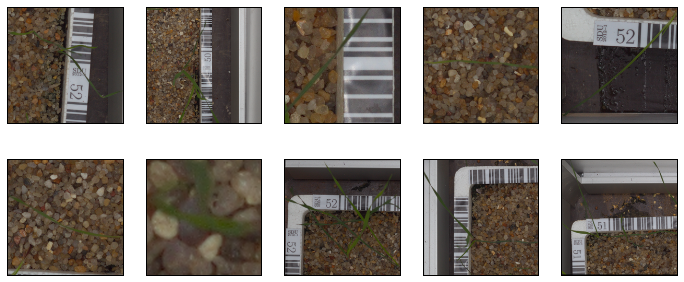

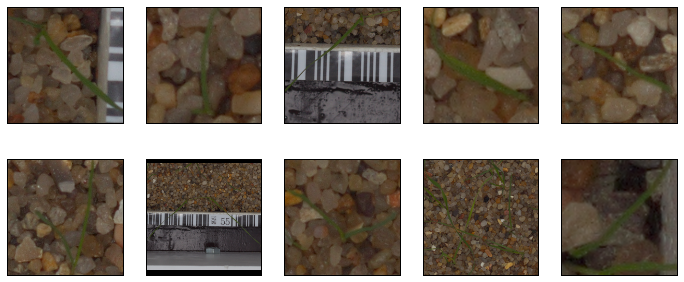

In [26]:
black_grass_imgs = train_data[np.where(train_labels_dense == 3)][:10]
loose_silkybent_imgs = train_data[np.where(train_labels_dense == 2)][:10]

fig1 = plt.figure(figsize=(12, 5))
for i, img in enumerate(black_grass_imgs):
    sub = fig1.add_subplot(2, 5, i + 1)
    sub.imshow(img)
    remove_ticks(sub)
    
fig2 = plt.figure(figsize=(12, 5))
for i, img in enumerate(loose_silkybent_imgs):
    sub = fig2.add_subplot(2, 5, i + 1)
    sub.imshow(img)
    remove_ticks(sub)

The two classes look very similar. This will make them difficult to differentiate. I can't even do it by eye. To make things worse, we saw in part 1 that there are relatively few examples for Black-grass, and more than double the number of Loose Silky-bent. This explains why Black-grass gets commonly mistaken for Loose Silky-Bent, but not the other way around. To address this issue, we could do the data augmentation differently. Before, the same number of transformations were applied on all exampled in the training set. Instead, we could try "evening things out" by applying more transformations to the classes with fewer examples.

## Plotting Greatest Sources of Loss

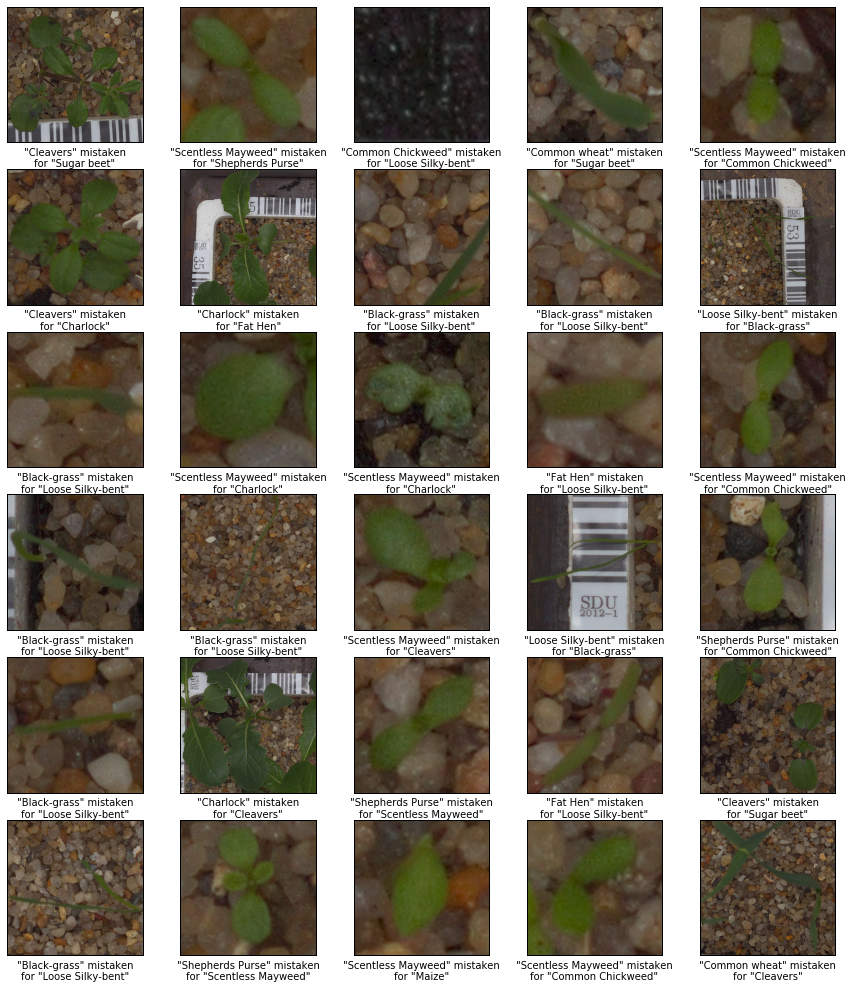

In [28]:
n_mistakes = 30
ind_biggest_mistakes = arg_top_n(dev_losses, n_mistakes)[0]

fig = plt.figure(figsize=(15, math.ceil(n_mistakes / 1.8)))
for i, mistake_ind in enumerate(ind_biggest_mistakes):
    sub = fig.add_subplot(math.ceil(n_mistakes / 5), 5, i + 1)
    example = dev_data[mistake_ind]
    sub.imshow(example)
    predicted_class = class_names[dev_predictions[mistake_ind]]
    actual_class = class_names[dev_labels_dense[mistake_ind]]
    sub.set_xlabel('"%s" mistaken\nfor "%s"' % (actual_class, predicted_class))
    remove_ticks(sub)

In these examples, there are a lot of examples of Black-grass confused as Loose Silky-bent. This was expected from the confusion matrix. There are a few examples of grainy, poorly lit photos. The biggest issue here seems to be that the small photos appear here fre